In [1]:
from emlib import emlib
import logging
emlib.emlog.setLevel(logging.INFO)

In [2]:
def NPZNB_int(t,initial,dtinput,constants):

    B = initial[0]             # benthos
    P = initial[1]             # phytoplankton
    Z = initial[2]             # zooplankton
    DIN = initial[3]           # dissolved inorganic
    DON = initial[4]           # dissolved organic
    ddin = dtinput.Val("ddin") #Concentration by day from WRTDS model 2 columns date and ddin Units are mg/L N
    ddon = dtinput.Val("ddon") #Concentration by day from WRTDS model 2 columns date and ddon mg/l N
    
    i = constants.Val("i")      #irradiance
    Pg = constants.Val("Pg")    # max P growth
    Bg = constants.Val("Bg")    # max B growth
    e = constants.Val("e")      # Z ingestion
    Zm = constants.Val("Zm")    # Z mortality
    Pm = constants.Val("Pm")    # P mortality
    Bm = constants.Val("Bm")    # B mortality
    Pe = constants.Val("Pe")    # P excretion
    Be = constants.Val("Be")    # B excretion
    Pr = constants.Val("Pr")    # P recycle
    h = constants.Val("h")      # Z grazing
    s = constants.Val("s")      # sedimentation
    f = constants.Val("f")      # flushing rate
    
    B_dot = (Bg * B)/ (1 + Bg * B) * (DON + DIN) - (Bm * B) - (Be * B * B)
    P_dot = (i * Pg * P * DIN) + (Pr * DON * P) - (h * P * Z) - (Pm * P * P) - (Pe * P)
    Z_dot = (h * e) - (h * P * Z) - (Zm * Z *Z )
   
    
    DIN_dot = ddin + (0.8* (1 - e) * h * P * Z) + (Be * B)+  (Pe * P) \
                - (i * Pg * P * DIN) - ((Bg * B)/ (1 + Bg * B) * (DIN)) - (f * DIN)
    DON_dot = ddon + (Bm * B)  +(Pm * P)  + (Zm * Z)  + (0.2 * (1 - e) * h * P * Z) \
             - (Pr * DON * P)  - ((Bg * B)/ (1 + Bg * B) * (DON))  - (s * DON) - (f * DON)
    return [B_dot,P_dot, Z_dot, DIN_dot, DON_dot]

In [3]:
NPZUS = emlib.Model(NPZNB_int) #save the model

INFO -1104- New Model(1): NPZNB_int
INFO -1116- No algorithm supplied assuming vode/bfd O12 Nsteps3000 dt1


In [4]:
nutrients= emlib.TimeSeries(dirname="Data",filename="Guadalupe_input.csv") #loading in input timeseries data ddin and ddon in same file
nutrients_alltime= emlib.TimeSeries(dirname="Data",filename="Guadalupe_inputall.csv")

benthos_observation = emlib.Observation ("B", dirname="Data",filename= "US_MG_Calibrate.csv")  
zoop_observation = emlib.Observation ("Z", dirname="Data",filename= "US_Zoop.csv")  
chla_observation = emlib.Observation ("P", dirname="Data",filename= "US_Chl.csv")  

NPZUScalibration = emlib.Calibration()  #all of our coefficients
NPZUScalibration.Add("i",val=2.54402, min= 0.01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("Pg",val=2.2672251,min= 0.01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("Bg",val=1.03903,min= 0.01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("e",val=1.77639,min= 0.01, max= 2.0)#from Turner 2014
NPZUScalibration.Add("Zm",val=0.028854,min= 0.01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("Pm",val=2.61708,min= 0.01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("Bm",val=1.18918,min= 0.01, max= 1.5)#from Turner 2014
NPZUScalibration.Add("Pe",val=1.24452553,min= 0.01, max= 3.0)#random number
NPZUScalibration.Add("Be",val=0.92205,min= 0.01, max= 1.5)#random number
NPZUScalibration.Add("Pr",val=2.2753,min= 0.01, max= 3.0)#random number
NPZUScalibration.Add("h",val=1.14171,min=0.01,max=3.0)#random moving number
NPZUScalibration.Add("s",val=0.11773830,min= .01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("f",val=0.0570468,min= .01, max= 2.0)#from Turner 2014
NPZUScalibration.initial=[0.5,0.5,0.5,0.5,0.5]

legend = ["B", "P", "Z", "DIN","DON"]   #our graph legend



INFO -879- New TimeSeries instance: 1
INFO -879- New TimeSeries instance: 2
INFO -758- Read file DataUS_MG_Calibrate.csv 74 Observations for value B
INFO -758- Read file DataUS_Zoop.csv 5 Observations for value Z
INFO -758- Read file DataUS_Chl.csv 13 Observations for value P
INFO -352- New Calibration instance: 1


In [ ]:
#calibrate to benthos, print out the coefficients and the calibration fitness


best = NPZUS.Calibrate (NPZUScalibration, benthos_observation, Algorithm=emlib.GF_BruteForceMSERANGE, runs =10000, TimeSeries= nutrients)
NPZUS.Integrate(NPZUScalibration.initial, Calibration=best,TimeSeries= nutrients, dt=0.01) 
NPZUS.Validate(benthos_observation, graph =True, legend=legend) 
NPZUS.fit.Print()
best.Print()

INFO -1393- New Best Calibration


Label	Value	Min	Max	ISConst	Desc
i 	 1.743680400717983 	 0.01 	 3.0 	 False 	 None
Pg 	 2.425684751408472 	 0.01 	 3.0 	 False 	 None
Bg 	 0.6653943624089722 	 0.01 	 3.0 	 False 	 None
e 	 0.16975009625824963 	 0.01 	 2.0 	 False 	 None
Zm 	 0.8678362092287416 	 0.01 	 3.0 	 False 	 None
Pm 	 2.8856608671355586 	 0.01 	 3.0 	 False 	 None
Bm 	 0.4535652434989341 	 0.01 	 1.5 	 False 	 None
Pe 	 0.5370390029203447 	 0.01 	 3.0 	 False 	 None
Be 	 1.2626723009724146 	 0.01 	 1.5 	 False 	 None
Pr 	 2.2451017191899734 	 0.01 	 3.0 	 False 	 None
h 	 1.5918251616908015 	 0.01 	 3.0 	 False 	 None
s 	 0.18811135449908994 	 0.01 	 3.0 	 False 	 None
f 	 1.7621079145095253 	 0.01 	 2.0 	 False 	 None
GFMODEL #63 Xtot:0.167 RMSD:0.0 RMSE:0.175 RANGE%4.8 MSER:1.3 WMSE:1.4


INFO -1393- New Best Calibration


Label	Value	Min	Max	ISConst	Desc
i 	 2.368118205288234 	 0.01 	 3.0 	 False 	 None
Pg 	 2.198829751352484 	 0.01 	 3.0 	 False 	 None
Bg 	 1.0363908143220835 	 0.01 	 3.0 	 False 	 None
e 	 1.8469849997676249 	 0.01 	 2.0 	 False 	 None
Zm 	 2.4440649235289356 	 0.01 	 3.0 	 False 	 None
Pm 	 0.8262500171901621 	 0.01 	 3.0 	 False 	 None
Bm 	 1.30551293273948 	 0.01 	 1.5 	 False 	 None
Pe 	 0.6632237030848178 	 0.01 	 3.0 	 False 	 None
Be 	 0.10342061695827037 	 0.01 	 1.5 	 False 	 None
Pr 	 1.4902217126879955 	 0.01 	 3.0 	 False 	 None
h 	 1.4021843009924349 	 0.01 	 3.0 	 False 	 None
s 	 0.1738643185187554 	 0.01 	 3.0 	 False 	 None
f 	 0.4269707446845181 	 0.01 	 2.0 	 False 	 None
GFMODEL #63 Xtot:0.167 RMSD:0.0 RMSE:0.126 RANGE%9.5 MSER:0.9 WMSE:1.0


INFO -1393- New Best Calibration


Label	Value	Min	Max	ISConst	Desc
i 	 1.5388837548827716 	 0.01 	 3.0 	 False 	 None
Pg 	 2.86445267071376 	 0.01 	 3.0 	 False 	 None
Bg 	 0.34499795127724786 	 0.01 	 3.0 	 False 	 None
e 	 0.9810027666069755 	 0.01 	 2.0 	 False 	 None
Zm 	 1.547044802960356 	 0.01 	 3.0 	 False 	 None
Pm 	 1.0863597608076654 	 0.01 	 3.0 	 False 	 None
Bm 	 0.4308742476237248 	 0.01 	 1.5 	 False 	 None
Pe 	 0.05872938667449004 	 0.01 	 3.0 	 False 	 None
Be 	 0.7374150238417458 	 0.01 	 1.5 	 False 	 None
Pr 	 0.7851984223306063 	 0.01 	 3.0 	 False 	 None
h 	 2.5196456277219763 	 0.01 	 3.0 	 False 	 None
s 	 2.328997929277618 	 0.01 	 3.0 	 False 	 None
f 	 0.8265668315355288 	 0.01 	 2.0 	 False 	 None
GFMODEL #63 Xtot:0.167 RMSD:5.4 RMSE:0.027 RANGE%25.4 MSER:0.1 WMSE:0.2


C:\Users\mrohal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
C:\Users\mrohal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
C:\Users\mrohal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
C:\Users\mrohal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))
INFO -1393- New Best Calibration


Label	Value	Min	Max	ISConst	Desc
i 	 2.5964246143973426 	 0.01 	 3.0 	 False 	 None
Pg 	 2.6921613263822293 	 0.01 	 3.0 	 False 	 None
Bg 	 0.11097000300258109 	 0.01 	 3.0 	 False 	 None
e 	 0.35581772776900766 	 0.01 	 2.0 	 False 	 None
Zm 	 2.302418294068517 	 0.01 	 3.0 	 False 	 None
Pm 	 1.4789911219560299 	 0.01 	 3.0 	 False 	 None
Bm 	 0.08513546824809551 	 0.01 	 1.5 	 False 	 None
Pe 	 1.709082193387775 	 0.01 	 3.0 	 False 	 None
Be 	 1.3475503948239034 	 0.01 	 1.5 	 False 	 None
Pr 	 1.957176608879883 	 0.01 	 3.0 	 False 	 None
h 	 0.7444517755998195 	 0.01 	 3.0 	 False 	 None
s 	 0.4696797343691163 	 0.01 	 3.0 	 False 	 None
f 	 1.1497705040621764 	 0.01 	 2.0 	 False 	 None
GFMODEL #63 Xtot:0.167 RMSD:22.9 RMSE:0.022 RANGE%38.1 MSER:0.1 WMSE:0.2


INFO -1393- New Best Calibration


Label	Value	Min	Max	ISConst	Desc
i 	 2.2050431513550603 	 0.01 	 3.0 	 False 	 None
Pg 	 2.218277811943027 	 0.01 	 3.0 	 False 	 None
Bg 	 0.05608411093698129 	 0.01 	 3.0 	 False 	 None
e 	 0.5390229409523539 	 0.01 	 2.0 	 False 	 None
Zm 	 1.9061340295036608 	 0.01 	 3.0 	 False 	 None
Pm 	 0.9432589218740262 	 0.01 	 3.0 	 False 	 None
Bm 	 0.03626921728187323 	 0.01 	 1.5 	 False 	 None
Pe 	 1.4171637940365787 	 0.01 	 3.0 	 False 	 None
Be 	 1.2263292080532826 	 0.01 	 1.5 	 False 	 None
Pr 	 2.603176105361221 	 0.01 	 3.0 	 False 	 None
h 	 1.8524668067845036 	 0.01 	 3.0 	 False 	 None
s 	 1.431283377145365 	 0.01 	 3.0 	 False 	 None
f 	 0.10690407496720683 	 0.01 	 2.0 	 False 	 None
GFMODEL #63 Xtot:0.167 RMSD:24.2 RMSE:0.021 RANGE%42.9 MSER:0.1 WMSE:0.2


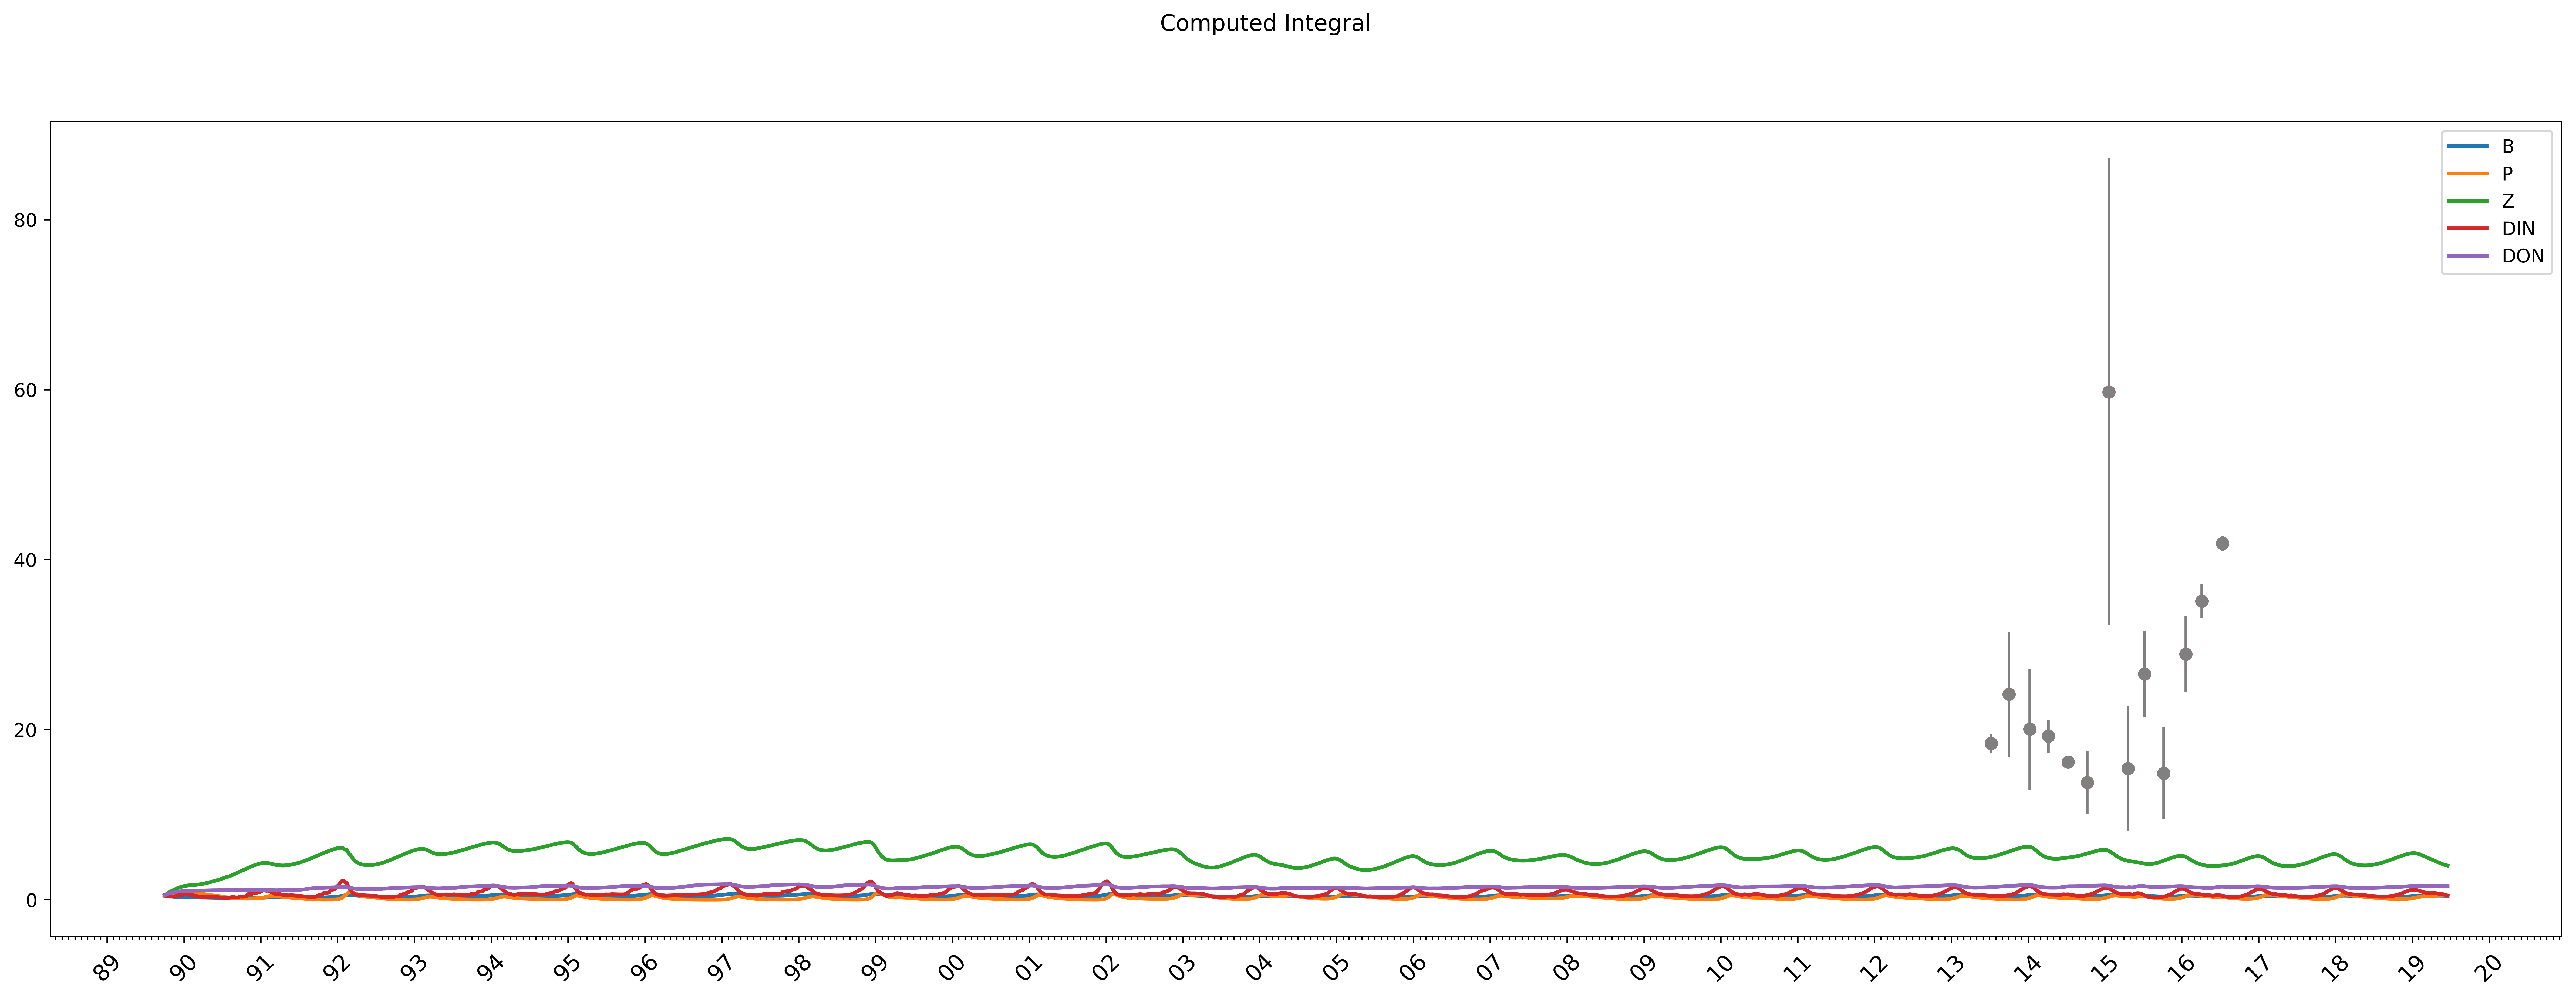

GFMODEL #13 Xtot:5.479 RMSD:5.8 RMSE:28.28 RANGE%0 MSER:78.7 WMSE:52.4
Label	Value	Min	Max	ISConst	Desc
i 	 2.54402 	 0.01 	 3.0 	 False 	 None
Pg 	 2.2672251 	 0.01 	 3.0 	 False 	 None
Bg 	 1.03903 	 0.01 	 3.0 	 False 	 None
e 	 1.77639 	 0.01 	 2.0 	 False 	 None
Zm 	 0.028854 	 0.01 	 3.0 	 False 	 None
Pm 	 2.61708 	 0.01 	 3.0 	 False 	 None
Bm 	 1.18918 	 0.01 	 1.5 	 False 	 None
Pe 	 1.24452553 	 0.01 	 3.0 	 False 	 None
Be 	 0.92205 	 0.01 	 1.5 	 False 	 None
Pr 	 2.2753 	 0.01 	 3.0 	 False 	 None
h 	 1.14171 	 0.01 	 3.0 	 False 	 None
s 	 0.1177383 	 0.01 	 3.0 	 False 	 None
f 	 0.0570468 	 0.01 	 2.0 	 False 	 None


In [10]:
#validate to CHLA
NPZUS.Integrate(NPZUScalibration.initial, Calibration=best,TimeSeries= nutrients_alltime, dt=0.01) 
NPZUS.Validate(chla_observation, graph =True, legend=legend) 
NPZUS.fit.Print()
best.Print()